# Data Pre-Processing

#### Import Packages and CSV

In [1]:
!pip install catboost
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# preprocessing functions and evaluation models
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

%matplotlib inline
# Supress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)


{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [4]:
df = pd.concat([X, y], axis=1)

In [5]:
df.to_csv("covertype.csv", index = False)

In [6]:
df = pd.read_csv("/content/covertype.csv")

**Import the CSV Data as Pandas DataFrame**

In [7]:
df = pd.read_csv('/content/covertype.csv')
print(df.shape)
df.head()

(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Data Cleaning
#### Checking features with nan value

In [8]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

**Handling Duplicates**

In [9]:
df.duplicated().sum()

np.int64(0)

# Feature Engineering
### Type of Features
**Numeric Features**

In [10]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Number of Numerical Features :', len(numeric_features))

Number of Numerical Features : 55


**Categorical Features**

In [11]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Number of Categorical Features :', len(categorical_features))

Number of Categorical Features : 0


**Discrete Features**

In [12]:
discrete_features=[feature for feature in numeric_features if (len(df[feature].unique())<=25)]
print('Number of Discrete Features :',len(discrete_features))

Number of Discrete Features : 45


**Continuous features**

In [13]:
continuous_features=[feature for feature in numeric_features if len(df[feature].unique()) > 25]
print('Number of Continuous Features :',len(continuous_features))

Number of Continuous Features : 10


### Check Outlier and Capping it
**Why outliers?**
* Data Entry error : Human error.
* Measurement error: Instrument error.
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

**Checking Outliers in Continuous features**

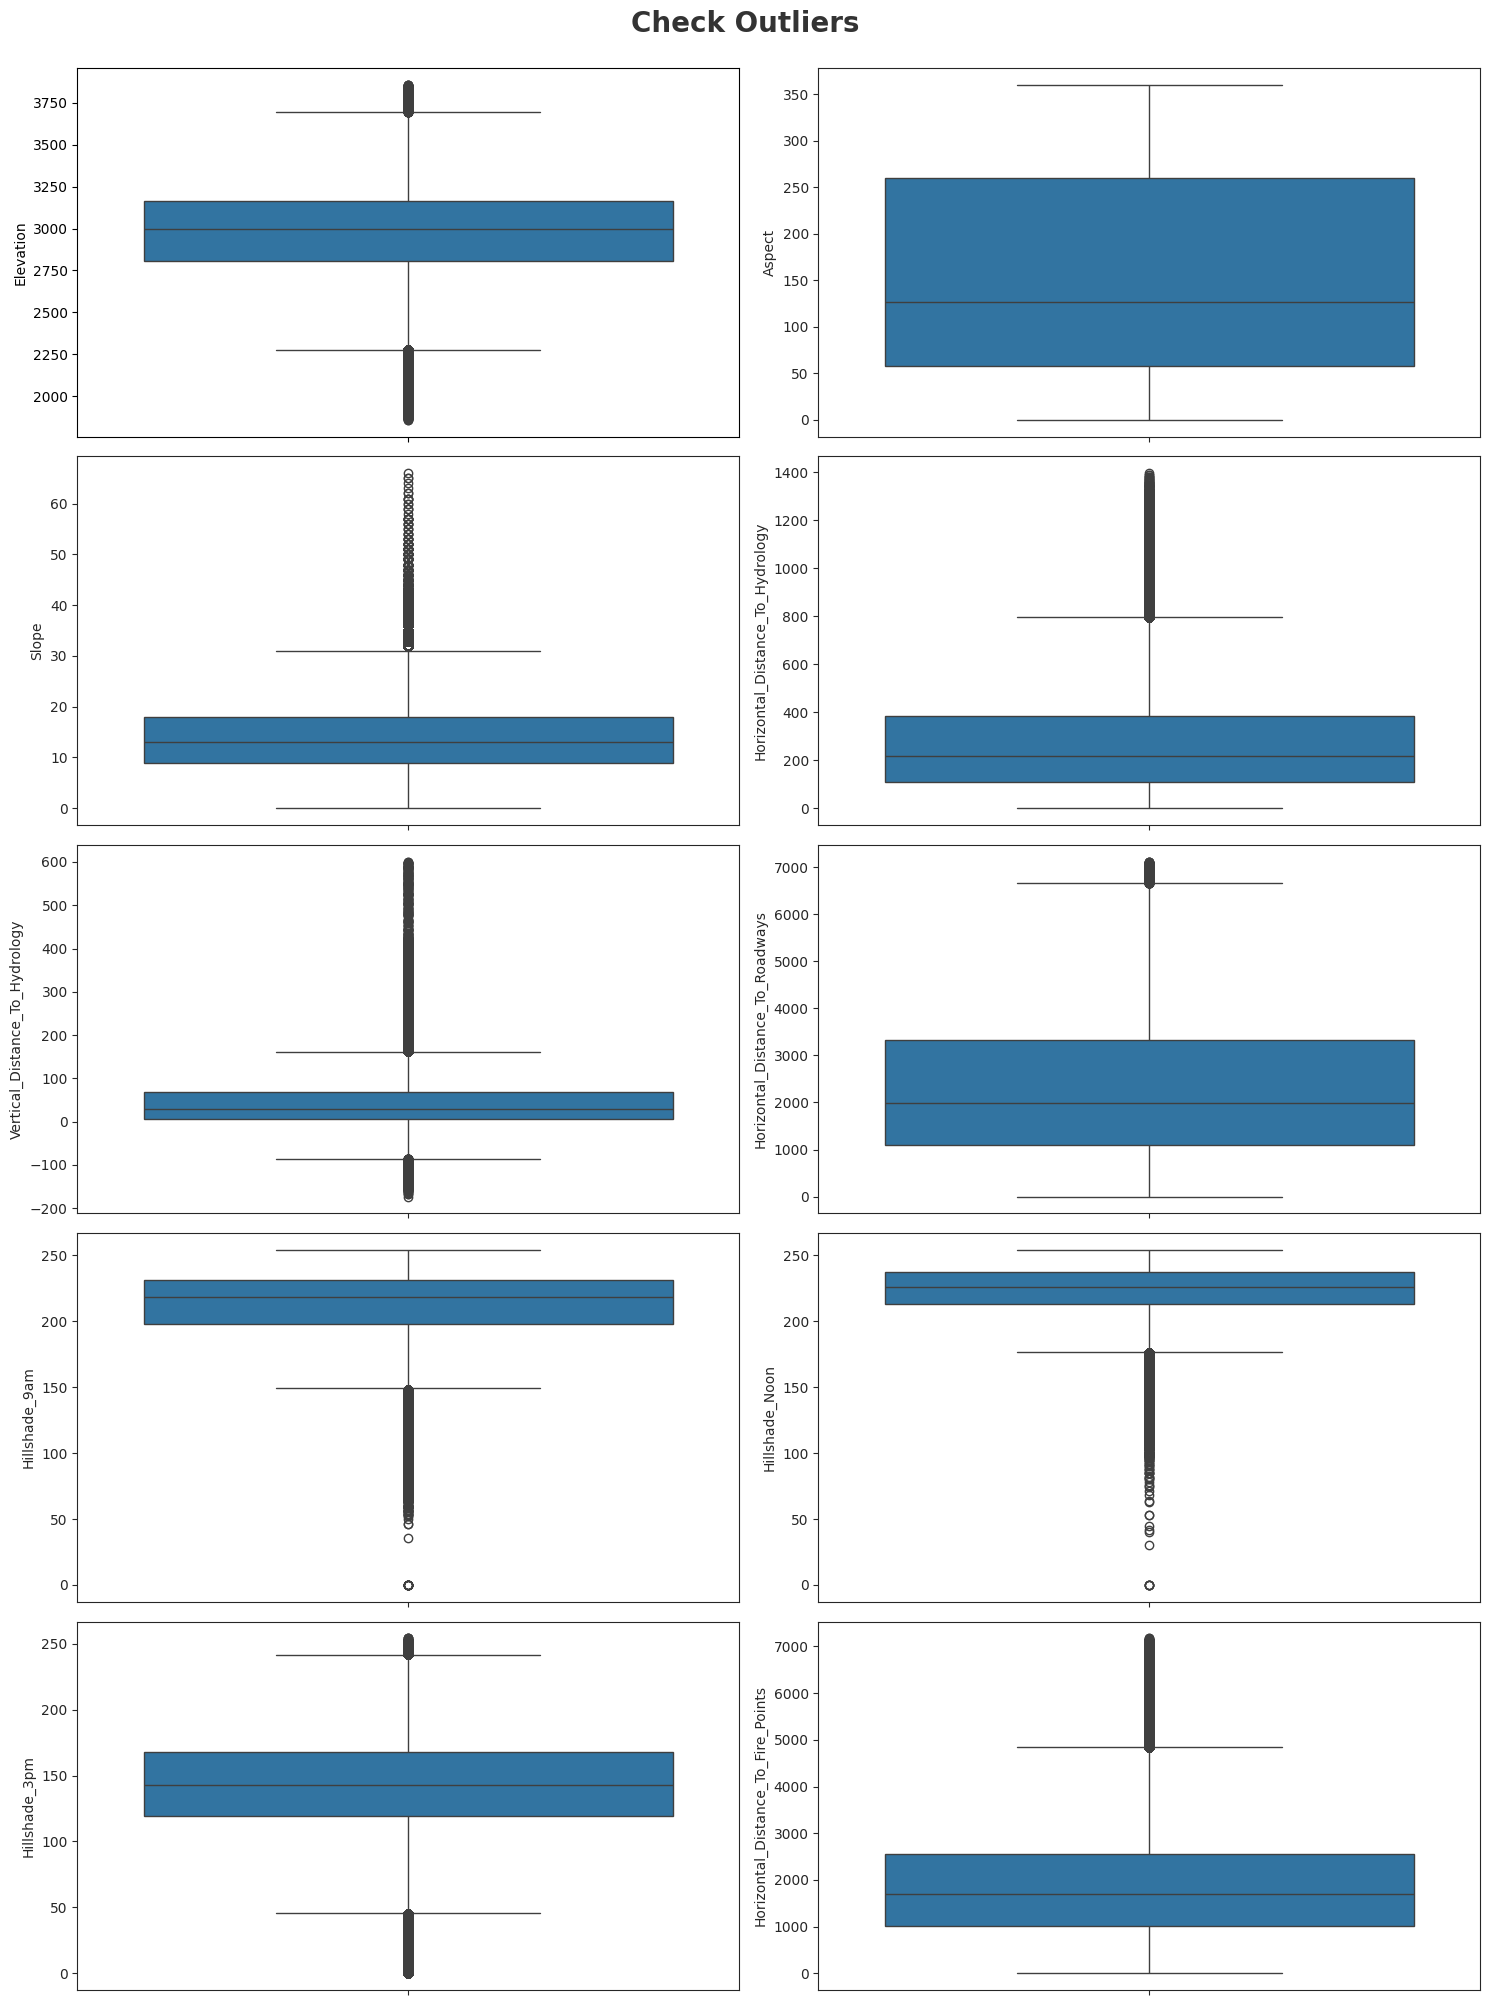

In [14]:
plt.figure(figsize=(15, 20))
plt.suptitle('Check Outliers', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(continuous_features)):
    plt.subplot(5, 2, i+1)
    sns.set_style('ticks')
    sns.boxplot(df[continuous_features[i]])
    plt.tight_layout()

#### Insight
- Except 'Aspect' rest all other 9 continuous features has outliers.

In [15]:
df_copy = df.copy()
def detect_and_capping_outliers(col):
    # Finding the IQR
    percentile25 = df_copy[col].quantile(0.25)
    percentile75 = df_copy[col].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df_copy.loc[(df[col]>upper_limit), col]= upper_limit
    df_copy.loc[(df[col]<lower_limit), col]= lower_limit
    return df_copy

In [16]:
for col in continuous_features:
         detect_and_capping_outliers(col)

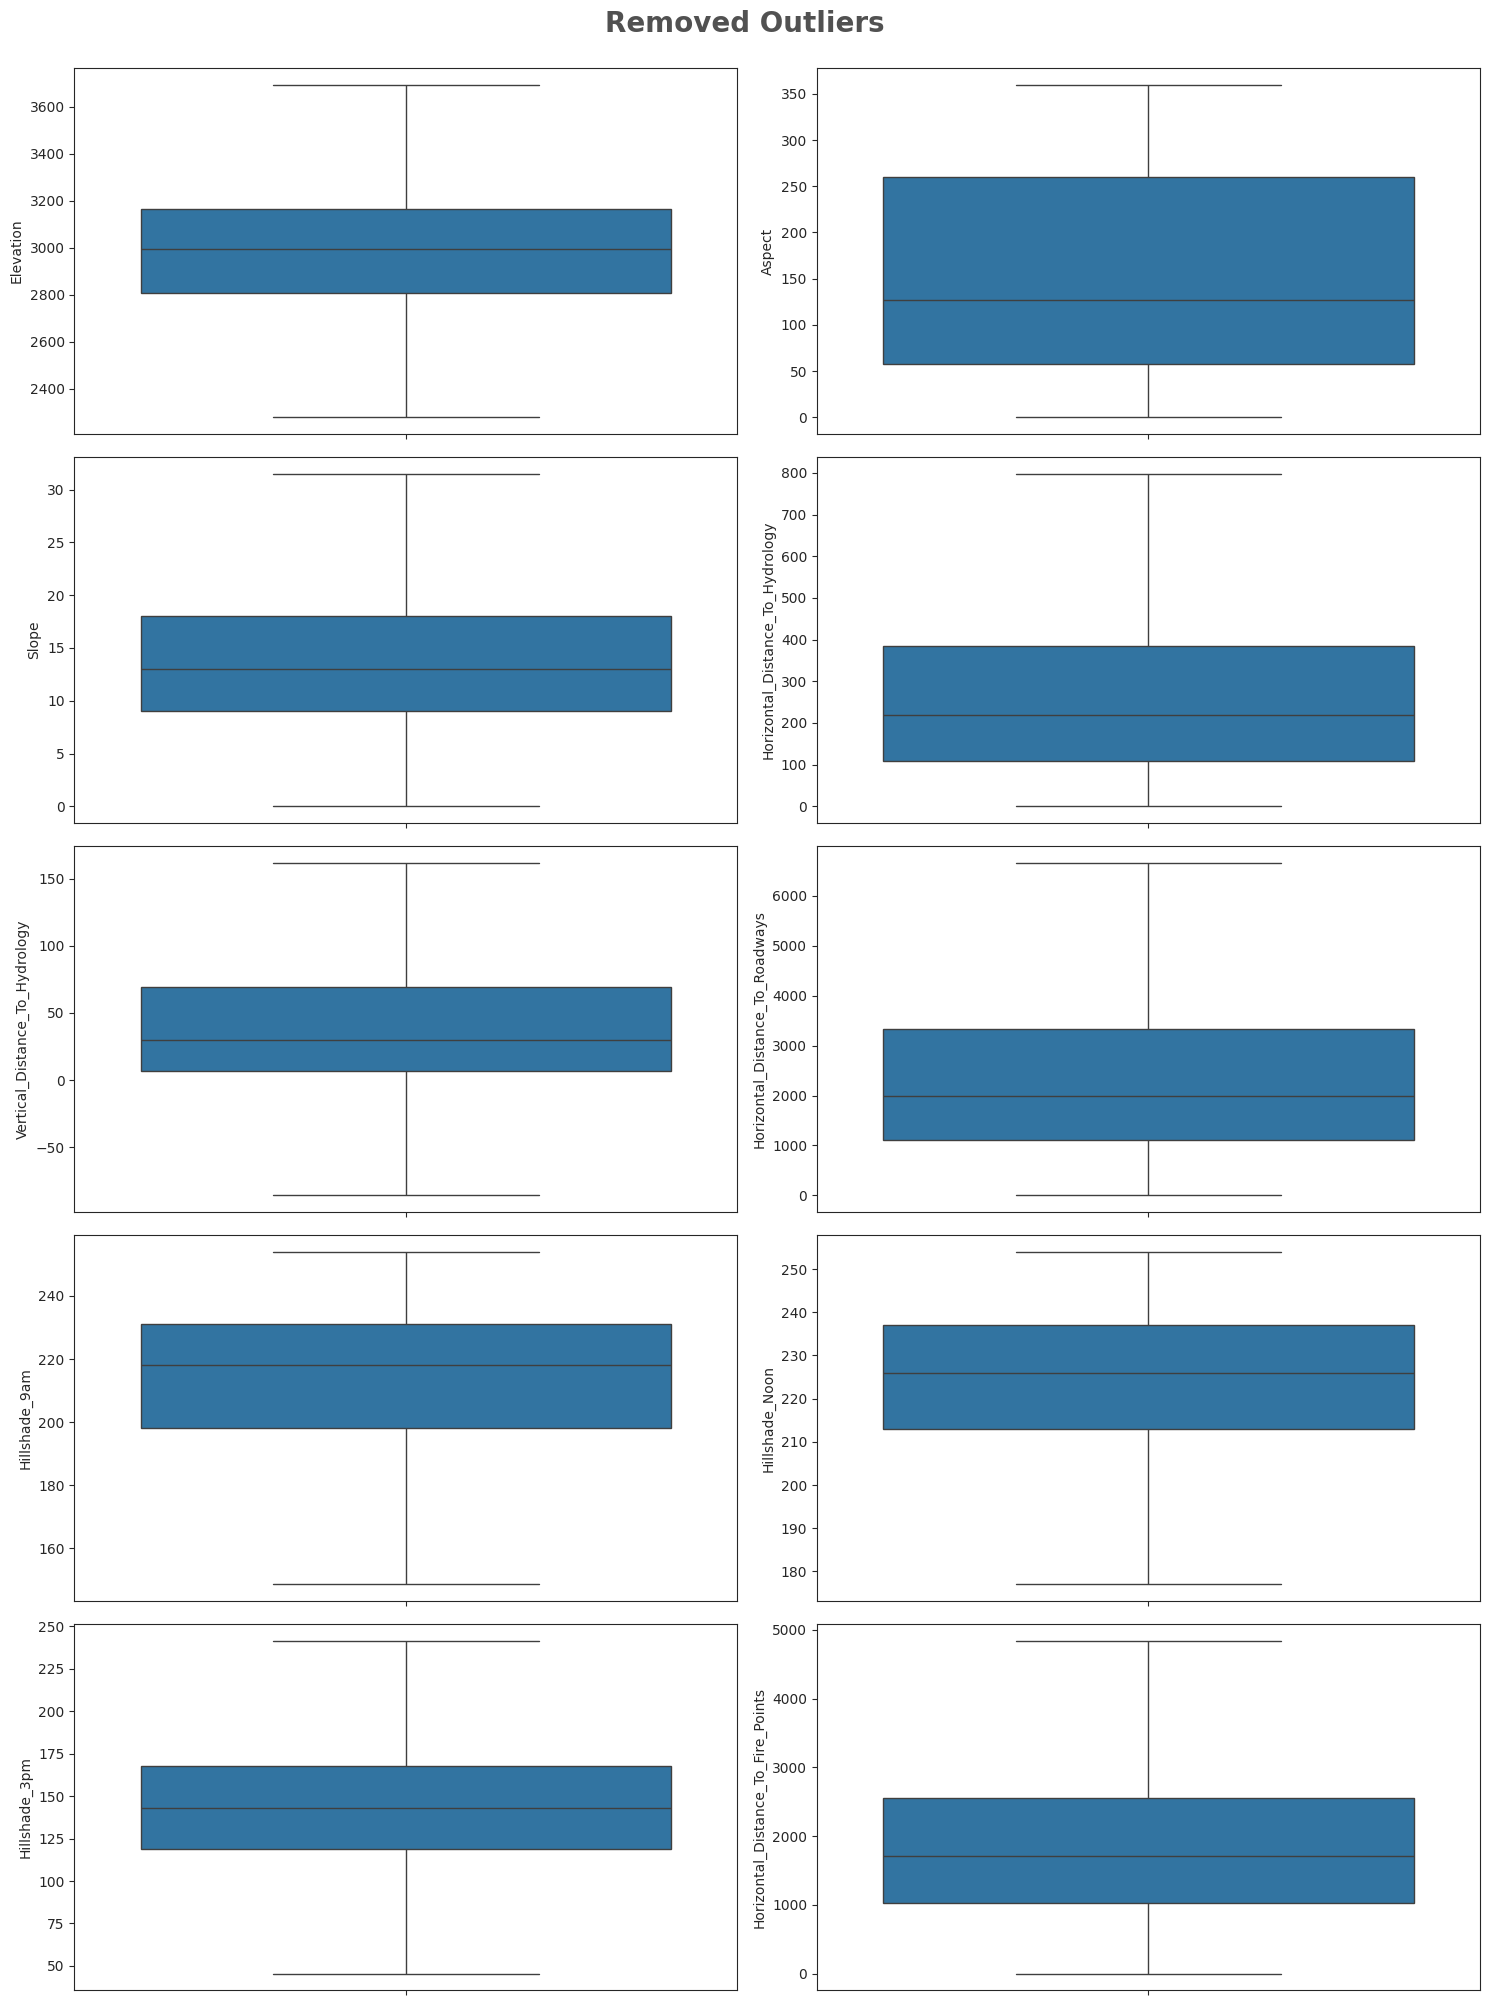

In [17]:
plt.figure(figsize=(15, 20))
plt.suptitle('Removed Outliers', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
for i in range(0, len(continuous_features)):
    plt.subplot(5, 2, i+1)
    sns.set_style('ticks')
    sns.boxplot(df_copy[continuous_features[i]])
    plt.tight_layout()

In [18]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Soil_Type1',
       'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
       'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4

#### Create one column as Wilderness_Area_Type and represent it as categorical data

In [19]:
df['Wilderness_Area_Type'] = (df.iloc[:, 10:15] == 1).idxmax(1)
#list of wilderness areas
wilderness_areas = sorted(df['Wilderness_Area_Type'].value_counts().index.tolist())

In [20]:
wilderness_areas

['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Wilderness_Area1']

In [21]:
def split_numbers_chars(row):
    '''This function fetches the numerical characters at the end of a string
    and returns alphabetical character and numerical charcters respectively'''
    head = row.rstrip('0123456789')
    tail = row[len(head):]
    return head, tail

def reverse_one_hot_encode(dataframe, start_loc, end_loc, numeric_column_name):
    ''' this function takes the start and end location of the one-hot-encoded column set and numeric column name to be created as arguments
    1) transforms one-hot-encoded columns into one column consisting of column names with string data type
    2) splits string column into the alphabetical and numerical characters
    3) fetches numerical character and creates numeric column in the given dataframe
    '''
    dataframe['String_Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1).idxmax(1)
    dataframe['Tuple_Column'] = dataframe['String_Column'].apply(split_numbers_chars)
    dataframe[numeric_column_name] = dataframe['Tuple_Column'].apply(lambda x: x[1]).astype('int64')
    dataframe.drop(columns=['String_Column','Tuple_Column'], inplace=True)

In [22]:
df_copy = df.copy()
reverse_one_hot_encode(df_copy, 14, 56, "Soil_Type")

In [23]:
feature_names = continuous_features + wilderness_areas + ["Soil_Type"] + ["Cover_Type"]
all_features_df = df_copy[feature_names]
all_features_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Wilderness_Area1,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,0,0,0,0,1,29,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,0,0,0,1,29,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,0,0,0,1,12,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,0,0,0,1,30,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,0,0,0,1,29,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,0,1,0,0,0,3,3
581008,2391,152,19,67,12,95,240,237,119,845,0,1,0,0,0,3,3
581009,2386,159,17,60,7,90,236,241,130,854,0,1,0,0,0,3,3
581010,2384,170,15,60,5,90,230,245,143,864,0,1,0,0,0,3,3


## Handling Imbalanced Target Variable(Cover_Type)

In [24]:
all_features_df["Cover_Type"] = all_features_df["Cover_Type"]-1

In [25]:
all_features_df["Cover_Type"].value_counts()

,count
Cover_Type,
1,283301
0,211840
2,35754
6,20510
5,17367
4,9493
3,2747


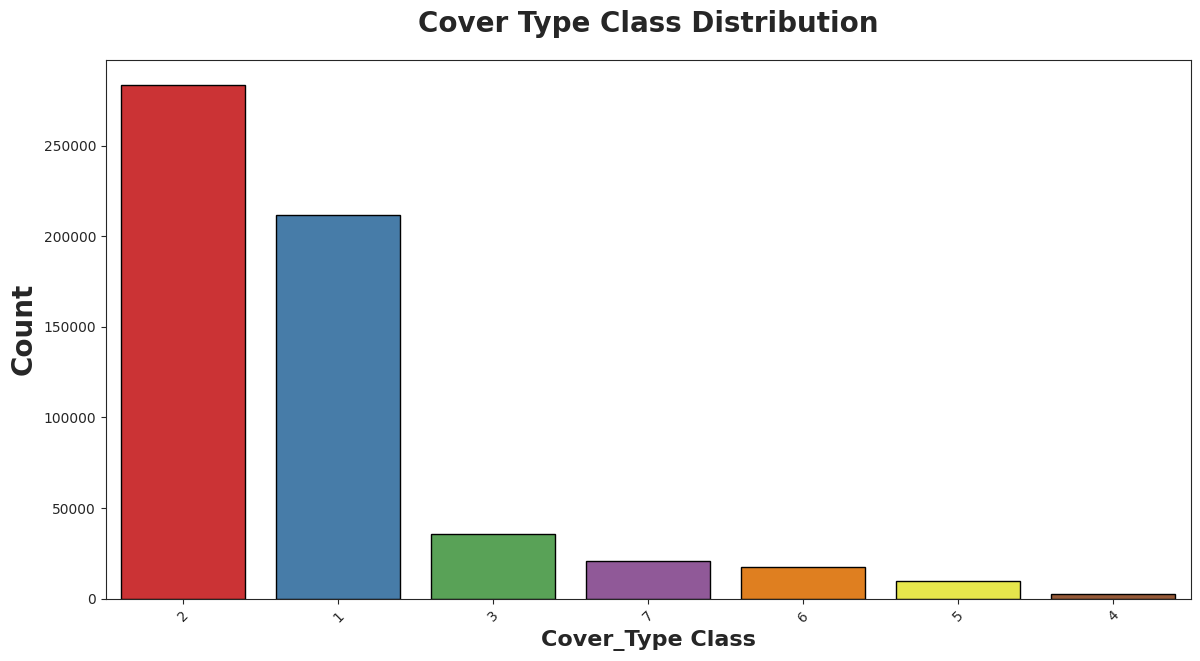

In [26]:
plt.subplots(figsize=(14,7))
sns.countplot(x="Cover_Type", data=df,ec = "black",palette="Set1",order = df['Cover_Type'].value_counts().index)
plt.title("Cover Type Class Distribution", weight="bold",fontsize=20, pad=20)
plt.ylabel("Count", weight="bold", fontsize=20)
plt.xlabel("Cover_Type Class", weight="bold", fontsize=16)
plt.xticks(rotation= 45)

plt.show()

#### Inference
- As most of the data is of class 0 and class 1 type.
- So its a clear case of imbalaced data

In [27]:
def split_and_scale_data(df):
    df = df.copy()

    # Split data in train and test set
    X = df.drop("Cover_Type", axis = 1)
    y = df["Cover_Type"]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    # Scale data using standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [28]:
def evaluate_model(model, blanced_class, X_test, y_test):
    model_accuracy = model.score(X_test, y_test)
    print("Accuracy({}):{:.2f}%".format(blanced_class, model_accuracy*100))

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cl_report = classification_report(y_test, y_pred)

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot= True, fmt='g', vmin=0,cbar= False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report", cl_report)
    return model_accuracy

In [ ]:
imbalanced_data = all_features_df.copy()
X_train, X_test, y_train, y_test = split_and_scale_data(imbalanced_data)

model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)

In [ ]:
evaluate_model(model_1,"Imbalanced",X_test, y_test)

In [ ]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)
evaluate_model(model_2,"Imbalanced",X_test, y_test)

In [ ]:
y_pred_probabilities = model_2.predict_proba(X_test)

In [ ]:
y_pred_probabilities

#### Inference
- From above confusion matrix we can observe that most of the true positives and true negatives are from class 1 and Class 2 only.
- We have huge disconnection between over represented classes and under represented classes.

### 1. Random under-sampling
####  It consists of removing samples from the majority class (under-sampling)

In [ ]:
under_sampled_data = all_features_df.copy()
under_sampled_data['Cover_Type'].value_counts()

In [ ]:
minimum_class_size = np.min(under_sampled_data['Cover_Type'].value_counts().values)
print("Size of smallest class:",minimum_class_size)

In [ ]:
class_subsets = [under_sampled_data.query("Cover_Type == " + str(i)) for i in range(7)]
class_subsets[0]

#### Undersample the majority class
- We will go through the each class subsets and sample 2747 records.

In [ ]:
class_subsets = [under_sampled_data.query("Cover_Type=="+str(i)) for i in range(7)]
for i in range(7):
    class_subsets[i] = class_subsets[i].sample(minimum_class_size)
under_sampled_data = pd.concat(class_subsets, axis=0).sample(frac=1.0).reset_index(drop=True)

In [ ]:
under_sampled_data['Cover_Type'].value_counts()

In [ ]:
X_train, X_test, y_train, y_test = split_and_scale_data(under_sampled_data)

model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)

In [ ]:
evaluate_model(model_1,"UnderSampling",X_test, y_test)

### 2. Random over-sampling
####   It consists of adding more examples from the minority class (over-sampling).

In [ ]:
over_sampled_data = all_features_df.copy()
maximum_class_size = np.max(over_sampled_data['Cover_Type'].value_counts().values)
print("Size of largest class:",maximum_class_size)

#### Oversampling the minority class
- We will go through the each class subsets and sample 2747 records.

In [ ]:
class_subsets = [over_sampled_data.query("Cover_Type=="+str(i)) for i in range(7)]
for i in range(7):
    class_subsets[i] = class_subsets[i].sample(maximum_class_size, replace=True,random_state=42)
over_sampled_data = pd.concat(class_subsets, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [ ]:
over_sampled_data['Cover_Type'].value_counts()

In [ ]:
X_train, X_test, y_train, y_test = split_and_scale_data(over_sampled_data)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

In [ ]:
evaluate_model(rf_classifier,"OverSampling",X_test, y_test)

#### Random Forest Classifier

In [ ]:
imbalanced_data = all_features_df.copy()
X_train, X_test, y_train, y_test = split_and_scale_data(imbalanced_data)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

#### In order to calculate roc_auc_score in multi class classification we need to mention strategies either as OvR and OvO strategies.

In [ ]:
# Make predictions
y_pred_probabilities = rf_classifier.predict_proba(X_test)
rf_roc_auc = roc_auc_score(y_test, y_pred_probabilities,multi_class="ovr") #Calculate Roc
print("roc_score",rf_roc_auc)
rf_accuracy =  evaluate_model(rf_classifier,"Imbalanced_data",X_test, y_test)

#### Extra Trees (Random Forests) Classifier

In [ ]:
xrf_classifier = ExtraTreesClassifier()
xrf_classifier.fit(X_train, y_train)
# Make predictions
y_pred_probabilities = xrf_classifier.predict_proba(X_test)
xrf_roc_auc = roc_auc_score(y_test, y_pred_probabilities,multi_class="ovr") #Calculate Roc
print("roc_score",xrf_roc_auc)
xrf_accuracy = evaluate_model(xrf_classifier,"Imbalanced",X_test, y_test)

#### Light Gradient Boosting Machine (LightGBM) Classifier

In [ ]:
# create model apply fit_evaluate_model
lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)
# Make predictions
y_pred_probabilities = lgbm_classifier.predict_proba(X_test)
lgbm_roc_auc = roc_auc_score(y_test, y_pred_probabilities,multi_class="ovr") #Calculate Roc
print("roc_score",lgbm_roc_auc)
lgbm_accuracy = evaluate_model(lgbm_classifier,"Imbalanced",X_test, y_test)

In [ ]:
# create model apply fit_evaluate_model
cat_classifier = CatBoostClassifier(verbose=False)
cat_classifier.fit(X_train, y_train)
# Make predictions
y_pred_probabilities = cat_classifier.predict_proba(X_test)
cat_roc_auc = roc_auc_score(y_test, y_pred_probabilities,multi_class="ovr") #Calculate Roc
print("roc_score",cat_roc_auc)
cat_accuracy = evaluate_model(cat_classifier,"Imbalanced",X_test, y_test)

In [ ]:
# create model apply fit_evaluate_model
xgb_classifier = XGBClassifier(verbose=False)
xgb_classifier.fit(X_train, y_train)
# Make predictions
y_pred_probabilities = xgb_classifier.predict_proba(X_test)
xgb_roc_auc = roc_auc_score(y_test, y_pred_probabilities,multi_class="ovr") #Calculate Roc
print("roc_score",cat_roc_auc)
xgb_accuracy = evaluate_model(xgb_classifier,"Imbalanced",X_test, y_test)

## Evaluate all base Models

In [ ]:
# create dataframe of accuracy and model and sort values
performance_comparison = pd.DataFrame({"Model": [ "LightGBM", "Random Forests", "Extra Trees","cat_accuracy","xgb_accuracy"],
                                       "Accuracy": [ lgbm_accuracy, rf_accuracy, xrf_accuracy,cat_accuracy,xgb_accuracy]})

performance_comparison = performance_comparison.sort_values(by="Accuracy", ascending=True)

# set the plot
plt.figure(figsize=(10,10))
ax = sns.barplot(x="Accuracy", y="Model", data=performance_comparison, palette="Greens_d")

# set title arrange labels
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Accuracy Score of Different Models", size=14)


## Plot Roc Auc Curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
#binarize the y_values

classes=np.unique(y_test)
y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = 7

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_pred_probabilities[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

### Best Model is Random Forest Classifier with 96 % Accuracy, hence we can save this model

In [ ]:
import pickle

# Save the trained model as a pickle file.
pickle.dump(rf_classifier, open('rf_classifier.pkl', 'wb'))